In [1]:
import pandas as pd
from pandarallel import pandarallel
from os import path
import re

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "cleaned_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text
221518,1559875782209568770,vdd é nojento uma vergonha 😡😡😡
579573,1160057933599838208,te acho gatinha era só uns bjs em tu..😏❤ — dm ...
944009,1160951144979619842,"relaxa, seu diálogo não era cabuloso. relaxa, ..."
237717,1559880687225815041,meu professor de cirurgia me chamando p acompa...
892145,1160887243831152642,"aí eu enterro já foi, só queria ir da um abraç..."
285660,1559894414029357056,kkk simmm porqueee
658832,1160594657325330432,"voa, vc merece mano 👊"
764603,1160714197631754240,amanhã vou la na loja pegar o famigerado conti...
122730,1559836810003595264,pra vc (e eu) q gosta de slow burn 👌👌👌
762889,1160713451129491459,vc vai achar alguém que te ame independente de...


### Emoji Lexicon

Emoji Sentiment Ranking


![Emoji Sentiment Ranking](images/emoji-sentiment-ranking.png)


Referências:

- [Emoji Sentiment Ranking](https://kt.ijs.si/data/Emoji_sentiment_ranking/index.html)
- *Kralj Novak P, Smailović J, Sluban B, Mozetič I (2015) Sentiment of Emojis. PLoS ONE 10(12): e0144296. [https://doi.org/10.1371/journal.pone.0144296](https://doi.org/10.1371/journal.pone.0144296)</a>*

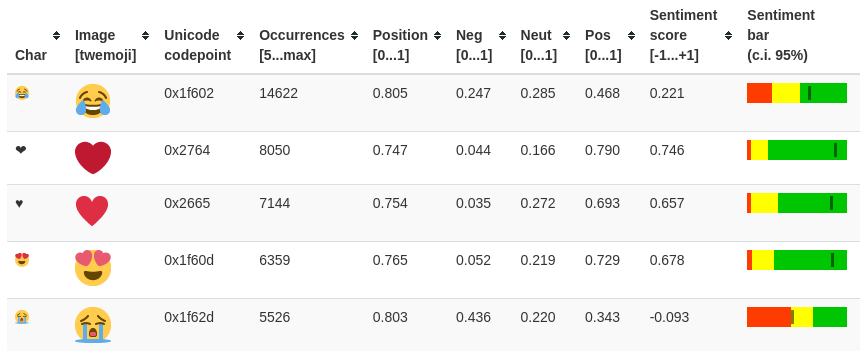

In [4]:
# Definir caminho do arquivo
filename = "emoji_sentiment_data.csv"

emoticon = pd.read_csv(filename)
emoticon["score"] = emoticon["score"].apply(lambda x: float(x.replace(",", ".")))
emoticon.sample(10)

,emoji,score
56,💚,0.659218
91,😑,-0.314381
107,😨,-0.141264
8,💕,0.632917
31,☯,0.001008
98,🐧,0.461268
93,😹,0.142373
29,🎉,0.739556
12,♡,0.669873
34,💙,0.732456


# Pre-Labeling

Aqui nós vamos fazer um pré-labeling, ou seja, realizar uma inferência inicial do sentimento dos tweets.

As inferências serão realizadas conforme os emojis.

## Filtrar Tweets sem os Emojis do Sentiment Ranking

Como vamos utilizar os emojis para fazer a inferência de sentimento, vamos remover os tweets que não possuem os emojis do Emojis do Sentiment Ranking

In [5]:
# Função para gerar e retornar o regex pattern que faz match em qualquer emoji do Emoji Sentiment Ranking
def get_emoji_regex_pattern(emoji_list):
    emoji_regex_pattern = "[" + "".join(emoji_list) + "]"
    return re.compile(emoji_regex_pattern)

In [6]:
# Função para calcular a quantidade de emojis do Emoji Sentiment Ranking
def get_amount_of_sentiment_emoji(text, regex_compiled):
    return len(regex_compiled.findall(text))

In [7]:
# Definir regex que faz match em qualquer emoji do Emoji Sentiment Ranking
regex = get_emoji_regex_pattern(emoticon["emoji"])
regex

re.compile(r'[😂❤♥😍😭😘😊👌💕👏😁☺♡👍😩🙏✌😏😉🙌🙈💪😄😒💃💖😃😔😱🎉😜☯🌸💜💙✨😳💗★█☀😡😎😢💋😋🙊😴🎶💞😌🔥💯🔫💛💁💚♫😞😆😝😪�😫😅👊💀😀😚😻©👀💘🐓☕👋✋🎊🍕❄😥😕💥💔😤😈►✈🔝😰⚽😑👑😹👉🍃🎁😠🐧☆🍀🎈🎅😓😣😐✊😨😖💤💓👎💦]',
           re.UNICODE)

In [8]:
# Criar a coluna quantidade emojis
data["quantidade_emojis"] = data["text"].parallel_apply(
    lambda x: get_amount_of_sentiment_emoji(x, regex)
)

In [9]:
data.sample(5)

,id,text,quantidade_emojis
70244,1559769095796662273,"em dias, bjs! kkk🙈",1
425116,1559950390921236486,ele foi perfeito po kkk pescar é uma arte,0
712230,1160679065029873669,o melhor momento do sudoeste!,0
46326,1559753250471043072,"te amo, te amo 💘",1
26878,1559745734412476419,jantinha 🙏😋🤩🤝,2


In [10]:
# Quantidade de tweets sem emojis válidos
data[data["quantidade_emojis"] == 0].shape[0]

282944

In [11]:
# Remover tweets sem emojis validos
data = data[data["quantidade_emojis"] > 0].reset_index(drop=True)

In [12]:
data.sample(5)

,id,text,quantidade_emojis
232405,1559910677040562176,"gêmeos,prima ama. 💞",1
37481,1559757987153158147,"eu amo tanto essa mulher, love u give me a hug...",1
405391,1160318390495535104,realizou l sonho de tanta gente 😝,1
574554,1160743736160247809,também to com saudade :( essa semana vou almoç...,1
10248,1559742140015599618,nao queria ir nao amiga😩😩😩,3


In [13]:
# Quantidade de Tweets com Emojis Válidos
data.shape[0]

911951

In [14]:
# Estatistica Descritiva da Quantidade de Emojis
data["quantidade_emojis"].describe()

count    911951.000000
mean          1.371631
std           1.058356
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         108.000000
Name: quantidade_emojis, dtype: float64

In [15]:
# Percentil 85
data["quantidade_emojis"].quantile(0.85)

2.0

In [16]:
# Percentil 90
data["quantidade_emojis"].quantile(0.90)

3.0

In [17]:
# Percentil 95
data["quantidade_emojis"].quantile(0.95)

3.0

## Atribuir Sentiment Score aos Tweets

Aqui vamos calcular o score do sentimentos dos tweets.

Definiremos o score do tweet como a soma do score de cada emoji presente naquele tweet

In [18]:
# Calcula o score de determinado tweet
def get_string_score(string, regex_compiled, emoji_dataframe):
    emojis = regex_compiled.findall(string)

    string_score = 0
    for emoji in emojis:
        string_score += emoji_dataframe[emoji_dataframe["emoji"] == emoji][
            "score"
        ].values[0]

    return string_score

In [19]:
# Definix Regex que faz match em qualquer emoji
regex = get_emoji_regex_pattern(emoticon["emoji"])
regex

re.compile(r'[😂❤♥😍😭😘😊👌💕👏😁☺♡👍😩🙏✌😏😉🙌🙈💪😄😒💃💖😃😔😱🎉😜☯🌸💜💙✨😳💗★█☀😡😎😢💋😋🙊😴🎶💞😌🔥💯🔫💛💁💚♫😞😆😝😪�😫😅👊💀😀😚😻©👀💘🐓☕👋✋🎊🍕❄😥😕💥💔😤😈►✈🔝😰⚽😑👑😹👉🍃🎁😠🐧☆🍀🎈🎅😓😣😐✊😨😖💤💓👎💦]',
           re.UNICODE)

In [20]:
# Exemplo da Função de Calcular Sentiment Score
texto = data["text"].sample().values[0]
print("Tweet:", texto)

get_string_score(texto, regex, emoticon)

Tweet: 📣 ™ 🆙 go book 🆙 💯 💯 🏛


0.241758241758242

In [21]:
# Calcular o sentiment score do dataset
data["score"] = data["text"].parallel_apply(
    lambda x: get_string_score(x, regex, emoticon)
)

In [22]:
data.sample(5)

,id,text,quantidade_emojis,score
70230,1559820315454210050,tá um tempo tão bom p dormir e n deixam eu fal...,1,-0.093377
620184,1160835952295780352,depois do trampooo haha.. de hj.. bom dia meus...,3,1.156423
387655,1160072609922461696,altas noite 😍,1,0.677937
335240,1559971595875131392,"vontade de matar um, q ódiooo 😤",1,-0.211009
788031,1161107263056175105,lomotif q vou postar no meu aniversário tá bra...,1,0.677937


In [23]:
# Estatistica Descritiva dos Scores dos Tweets
data["score"].describe()

count    911951.000000
mean          0.425308
std           0.653078
min         -12.319187
25%          -0.080780
50%           0.449977
75%           0.677937
max          74.717813
Name: score, dtype: float64

In [24]:
# Estatistica Descritiva de Tweets com apenas 1 emoji
data_tweets_1 = data[data["quantidade_emojis"] == 1]
data_tweets_1["score"].describe()

count    731828.000000
mean          0.299976
std           0.356789
min          -0.400000
25%          -0.080913
50%           0.411765
75%           0.657615
max           0.767361
Name: score, dtype: float64

In [25]:
# Estatistica Descritiva de Tweets com mais de 1 emoji
data_tweets_maior_que_1 = data[data["quantidade_emojis"] > 1]
data_tweets_maior_que_1.describe()

,quantidade_emojis,score
count,180123.000000,180123.000000
mean,2.881542,0.934525
std,1.682300,1.148509
min,2.000000,-12.319187
25%,2.000000,0.297872
50%,3.000000,0.871616
75%,3.000000,1.410393
max,108.000000,74.717813


# Atribuir Label

A partir do score dos tweets vamos inferir se o tweet é positivo, negativo ou neutro.

## Definir limiares positivos, negativos e neutros

Os limiares são as definições dos limites do score onde um tweet para a ser considerado positivo, negativo ou neutro.

In [26]:
# Estatística Descritiva dos Emojis
emoticon.describe()

,score
count,113.000000
mean,0.315515
std,0.329787
min,-0.400000
25%,0.063415
50%,0.417804
75%,0.622074
max,0.767361


In [27]:
# Estatística Descritiva dos Emojis Positivos
emoticon[emoticon["score"] > 0]["score"].describe()

count    89.000000
mean      0.451858
std       0.215704
min       0.001008
25%       0.288931
50%       0.464146
75%       0.656017
max       0.767361
Name: score, dtype: float64

In [28]:
# Estatística Descritiva dos Emojis Negativos
emoticon[emoticon["score"] < 0]["score"].describe()

count    24.000000
mean     -0.190092
std       0.113593
min      -0.400000
25%      -0.236037
50%      -0.164998
75%      -0.112160
max      -0.019868
Name: score, dtype: float64

In [29]:
# Limiares

# Como a grande maioria dos tweets possuem apenas um emoji, os limiares foram escolhidos a partir de análise visual da Sentiment Bar do Emoji Sentiment Ranking
## Ponto de atenção: como poderíamos melhorar esse limiar?
limiar_positivo = 0.250
limiar_negativo = -0.063

print("Limiar Positivo: {}".format(limiar_positivo))
print("Limiar Negativo: {}".format(limiar_negativo))

Limiar Positivo: 0.25
Limiar Negativo: -0.063


## Definir a Label

In [30]:
# Função que retorna a label de acordo com os limiares
def get_label(score, limiar_positivo, limiar_negativo):
    if score <= limiar_negativo:
        return -1

    if score >= limiar_positivo:
        return 1

    return 0

In [31]:
# Exemplo da Função de Calcular Sentiment Score
tweet = data.sample()
print("Tweet:", tweet["text"].values[0])

score = get_label(tweet["score"].values[0], limiar_positivo, limiar_negativo)
print("Label:", score)

Tweet: época de eleição até mort ressuscita 😂
Label: 0


In [32]:
# Obter a Label do Tweet
data["label"] = data["score"].parallel_apply(
    lambda x: get_label(x, limiar_positivo, limiar_negativo)
)

In [33]:
data.sample(5)

,id,text,quantidade_emojis,score,label
44232,1559764775650869250,tmj d+ meu mano 🙅🏽‍♂️✅🔥🎧,1,0.139785,0
717035,1160977484403417089,menos duas companhias pra hipno 😪,1,-0.080913,-1
249147,1559916875353657346,aí esse vídeo vai de zero a em questões de seg...,2,0.441937,1
273881,1559947118483234816,misericórdia até eu quero ti visitar kkk també...,3,0.662905,1
100320,1559849745039900672,howw 😂😂,2,0.441937,1


In [34]:
data.groupby("label")["score"].describe().T

label,-1,0,1
count,247910.000000,131570.000000,532471.000000
mean,-0.195951,0.155333,0.781265
std,0.144953,0.080804,0.628225
min,-12.319187,-0.062938,0.250146
25%,-0.280130,0.120879,0.522114
50%,-0.146058,0.179654,0.669873
75%,-0.093377,0.220968,0.746087
max,-0.063182,0.249750,74.717813


# Salvar os dados

In [35]:
# Filtrar os campos
data = data[["id", "text", "score", "label"]]
data.sample(5)

,id,text,score,label
109008,1559855134578016257,só a cabecinha... 😜,0.456039,1
254988,1559918867832573958,como é bom ser fã dele 🥺💛,0.712625,1
525439,1160704488828821504,"estou entre amor e tristeza com os trechos, se...",-0.093377,-1
510894,1160686830368514048,cigaro* 😔,-0.146058,-1
481876,1160640119956750336,principe da mamãe 💙,0.732456,1


In [36]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Salvar Dados
data.to_parquet(filepath, compression="gzip")